In [10]:
def get_positions(
    price_df: pd.DataFrame,
    signal_df: pd.DataFrame,
    holding_period: int = 1,
    shift_days: int = 1
):
    '''
    Returns the daily returns for all the assets

    price_df : pandas DataFrame of daily asset prices
        * can contain either just close prices or all OHLC
        * should have multi-level column index:
            * topmost level should be the asset
            * second level should be ["PX_OPEN", "PX_HIGH", "PX_LOW", "PX_LAST"] for open, high, low, close prices respectively

    signal_df : pandas DataFrame indicating the signals (assumed to be +1 for long, -1 for short, 0 otherwise)
        * column headers should contain the assets, and should match the column headers in price_df

    holding_period (optional) : days to remain in the position after the signal is triggered. defualt is 1.
        * this is mainly for trigger-type signals, e.g. crossing a bollinger band, not for buy-and-hold

    shift_days (optional) : days to shift the signal by to determine when the position is entered. defualt is 1.
    '''
    final_position_dict = {}
    for ticker in signal_df.columns:
        prices = price_df[ticker].dropna(how = 'all', subset = ['PX_LAST'])
        signals = signal_df[ticker]
        daily_index = pd.bdate_range(start = prices.index[0], end = prices.index[-1])
        signals = signals.reindex(daily_index.union(signals.index)).ffill().reindex(prices.index)
        position = signals.fillna(0)
        if holding_period > 1:
            position = position.where(position != 0)
            position = position.ffill(limit = (holding_period - 1))
            position = position.fillna(0)
        position = position.shift(shift_days)
        final_position_dict[ticker] = position
    return pd.concat(final_position_dict, axis = 1).ffill().rename_axis('date').rename_axis('ticker', axis = 1)


def get_strat_returns(
    price_df: pd.DataFrame,
    position_df: pd.DataFrame,
    cost: float = 0,
    use_open_prices: bool = True,
    daily_rebalance_shorts: bool = False
):
    '''
    Returns the daily returns for all the assets

    price_df : pandas DataFrame of daily asset prices
        * can contain either just close prices or all OHLC
        * should have multi-level column index:
            * topmost level should be the asset
            * second level should be ["PX_OPEN", "PX_HIGH", "PX_LOW", "PX_LAST"] for open, high, low, close prices respectively

    position_df : pandas DataFrame indicating the position for each asset on each date.
        * column headers should contain the assets, and should match the column headers in price_df
        * ideally, this should be the output of the `get_positions` function

    cost (optional) : trading costs as a percentage of change in position (e.g. put `cost = 1` for 1%), default is 0

    use_open_prices (optional) : trade on next day open instead of close, default is True, but only works if "PX_OPEN" is provided

    daily_rebalance_shorts (optional) : decides whether you rebalance a short exposure everyday after mark-to-market, default is False
    '''
    daily_rets_dict = {}
    for ticker in position_df.columns:
        price = price_df[ticker]
        price = price[~price['PX_LAST'].isnull()]
        if use_open_prices is True:
            price["PX_OPEN"] = price["PX_OPEN"].fillna(price["PX_LAST"])
        pos = position_df[ticker].reindex(price.index)
        daily_rets_dict[ticker] = get_strat_asset_returns(price, pos, cost, use_open_prices, daily_rebalance_shorts)
    return pd.concat(daily_rets_dict, axis = 1).fillna(0)




def get_strat_asset_returns(prices: pd.Series, positions: pd.Series, cost: float = 0, use_open_prices: bool = True, daily_rebalance_shorts: bool = False):
    close = prices["PX_LAST"].ffill()
    if use_open_prices:
        open = prices["PX_OPEN"].ffill()
    else:
        open = close.shift()

    close_to_close = close.pct_change().fillna(0)
    open_to_close = (close / open - 1).fillna(0)
    yest_close_to_open = (open / close.shift(1) - 1).fillna(0)

    if daily_rebalance_shorts:
        rets = positions.shift(fill_value = 0) * yest_close_to_open + positions * open_to_close
    else:
        long_pos = positions.clip(lower = 0)
        long_pos_chg = long_pos.diff().fillna(long_pos)
        long_rets = (long_pos.shift(fill_value = 0) * close_to_close) + (long_pos_chg * open_to_close)

        short_pos = positions.clip(upper = 0).abs()
        short_rets = get_short_daily_rets(open, close, short_pos)
        rets = long_rets + short_rets

    abs_pos_chg = positions.diff().fillna(positions).abs()
    return rets - ((cost / 100) * abs_pos_chg)

def get_short_daily_rets(open: pd.Series, close: pd.Series, short_pos: pd.Series):
    if np.ravel(short_pos.dropna() == 0).all():
        return short_pos
    else:
        comb = pd.concat({"open" : open, "close" : close, "short_pos" : short_pos}, axis = 1).dropna()
        short_pos_chg = comb["short_pos"].diff().fillna(comb["short_pos"])
        short_aum_matrix = __get_short_aum_matrix(comb["open"].values, comb["close"].values, comb["short_pos"].values, short_pos_chg.values)
        short_aum = pd.Series(short_aum_matrix, comb.index)
        return (short_aum / short_aum.shift(fill_value = 1) - 1).fillna(0)

def __get_short_aum_matrix(open: np.ndarray, close: np.ndarray, short_pos: np.ndarray, short_pos_chg: np.ndarray) -> np.ndarray:
    # size in asset units
    short_size = open * 0
    short_cash_flow_buy = open * 0
    short_cash_flow_cover = open * 0
    short_unrealised = open * 0
    short_aum = open * 0

    short_aum[0] = 1
    short_size[0] = 0
    short_cash_flow_buy[0] = 0
    short_cash_flow_cover[0] = 0
    short_unrealised[0] = 0
    for i in range(1, short_aum.shape[0]):
        if short_pos_chg[i] == 1:
            # Just entered short position
            short_size[i] = short_aum[i-1] / open[i]
            short_cash_flow_buy[i] = short_aum[i-1]
        elif short_pos[i] == 1:
            # In a short position
            short_size[i] = short_size[i-1]
            short_cash_flow_buy[i] = short_cash_flow_buy[i-1]
        else:
            short_size[i] = 0
            short_cash_flow_buy[i] = 0

        short_cash_flow_cover[i] = short_size[i] * close[i]

        if short_pos[i] == 1:
            # In a short position
            short_unrealised[i] = short_cash_flow_buy[i] - short_cash_flow_cover[i]
        elif short_pos_chg[i] == -1:
            # Just exited short position
            short_unrealised[i] = short_unrealised[i-1] + short_size[i-1] * (close[i-1] - open[i])
        else:
            short_unrealised[i] = 0

        if short_pos[i] == 1 or short_pos_chg[i] == -1:
            short_aum[i] = short_aum[i-1] + short_unrealised[i] - short_unrealised[i-1]
        else:
            short_aum[i] = short_aum[i-1]
    return short_aum





In [2]:
px = read_prices("../Dymon/Code Data/carry_adj_fx_returns.csv")

In [17]:
a = pd.read_csv("../Dymon/Code Data/NUS_Data.csv")

c:\users\vin_s\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [24]:
b = a.iloc[3:]
b = b.set_index("Unnamed: 0")

In [42]:
b["IDR"]

date
2000-01-03        NaN
2000-01-04        NaN
2000-01-05        NaN
2000-01-06        NaN
2000-01-07        NaN
               ...   
2021-08-02    14555.0
2021-08-03    14426.0
2021-08-04    14385.0
2021-08-05    14415.0
2021-08-06    14449.0
Name: IDR, Length: 5857, dtype: object

In [27]:
b["AUD"].index.name = "date"

In [31]:
b["AUD"]

date
2000-01-03    0.6585
2000-01-04     0.655
2000-01-05    0.6579
2000-01-06    0.6533
2000-01-07    0.6549
               ...  
2021-08-02    0.7361
2021-08-03    0.7396
2021-08-04    0.7379
2021-08-05    0.7405
2021-08-06    0.7356
Name: AUD, Length: 5857, dtype: object

In [38]:
c["PX_LAST"].pct_change()

2000-01-03         NaN
2000-01-04   -0.005330
2000-01-05    0.004411
2000-01-06   -0.007007
2000-01-07    0.002401
                ...   
2021-08-02    0.002309
2021-08-03    0.004749
2021-08-04   -0.002304
2021-08-05    0.003519
2021-08-06   -0.002715
Name: PX_LAST, Length: 5635, dtype: float64

In [32]:
c = px["AUDUSD"].dropna(how = 'all', subset = ['PX_LAST'])

In [5]:
sig = px.ffill()*0+1
sig.columns = [x[0] for x in sig.columns]

In [6]:
ret = get_strat_returns(price_df=px.ffill(), position_df=get_positions(price_df=px.ffill(),signal_df=sig), use_open_prices=False)

In [11]:
get_returns_stats(ret,position=get_positions(price_df=px.ffill(),signal_df=sig))

C:\Users\vin_s\AppData\Local\Temp/ipykernel_38064/1702586618.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ticker_stats = pd.Series()


,AUDUSD,USDCAD,USDCHF,USDCNY,EURUSD,GBPUSD,USDINR,USDJPY,USDKRW,USDNOK,NZDUSD,USDPHP,USDSEK,USDSGD,USDTHB,USDTWD,USDIDR,USDMYR,USDCNH
annualized_return,3.239985,-1.174856,-1.458885,-1.370168,0.48561,0.067692,-2.881259,1.72096,-1.157283,-1.074022,4.427379,-3.137211,-0.193414,-0.403633,-2.056083,1.088409,-5.470243,-0.32563,-1.219398
sharpe,0.262585,-0.135182,-0.132108,-0.580889,0.05142,0.007424,-0.425491,0.17868,-0.112103,-0.088973,0.353666,-0.425977,-0.016622,-0.079481,-0.41342,0.242739,-0.523029,-0.053994,-0.448087
dollar_sharpe,0.175157,-0.200342,-0.198224,-0.596887,0.003664,-0.035015,-0.491354,0.125596,-0.153276,-0.176367,0.250457,-0.386171,-0.080842,-0.103383,-0.413048,0.211718,-0.502382,-0.088379,-0.471092
trade_sharpe,0.262585,-0.135182,-0.132108,-0.580889,0.05142,0.007424,-0.425491,0.17868,-0.112103,-0.088973,0.353666,-0.425977,-0.016622,-0.079481,-0.41342,0.242739,-0.523029,-0.053994,-0.448087
long_sharpe,0.262608,-0.135194,-0.132119,-0.580941,0.051425,0.007424,-0.425529,0.178696,-0.112113,-0.088981,0.353697,-0.426015,-0.016623,-0.079488,-0.413456,0.242761,-0.53815,-0.061045,-0.629209
short_sharpe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sortino,0.175713,-0.100372,-0.077585,-0.333623,0.038746,0.005158,-0.296445,0.124822,-0.074888,-0.069383,0.249661,-0.256848,-0.012519,-0.05713,-0.29805,0.164234,-0.318499,-0.031429,-0.220625
max_drawdown,-50.16853,-61.127836,-84.658256,-36.127333,-43.846036,-55.705158,-67.787975,-46.722609,-56.446625,-84.666885,-43.126142,-95.583655,-72.088607,-36.461261,-76.345487,-13.950972,-138.972048,-30.537122,-29.202376
max_drawdown_start,2013-04-11,2002-01-18,2001-07-05,2006-08-15,2008-07-11,2007-11-08,2000-09-19,2007-06-22,2009-03-02,2000-10-25,2008-03-13,2000-10-27,2001-06-11,2001-12-27,2001-04-26,2009-03-02,2001-04-26,2009-03-05,2010-09-01
max_drawdown_end,2020-03-19,2011-07-21,2011-08-09,2021-05-28,2020-03-20,2020-03-19,2021-05-28,2011-10-28,2014-07-03,2013-02-01,2009-03-02,2021-05-31,2014-03-18,2011-08-16,2020-12-17,2011-05-11,2021-02-15,2013-05-08,2021-05-28


In [14]:
ret.sum(axis=1)

2000-01-03    0.000000
2000-01-04    0.000000
2000-01-05    0.021987
2000-01-06    0.049992
2000-01-07   -0.004181
                ...   
2021-08-02   -0.004755
2021-08-03   -0.002202
2021-08-04    0.005846
2021-08-05    0.013069
2021-08-06    0.007136
Length: 5636, dtype: float64

In [13]:
import pyfolio as pf

c:\users\vin_s\appdata\local\programs\python\python39\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [50]:
a = px["USDJPY"].dropna(how = 'all', subset = ['PX_LAST'])["PX_LAST"].diff()

In [51]:
b = px["USDJPY"].dropna(how = 'all', subset = ['PX_LAST'])["PX_LAST"].pct_change()

<AxesSubplot:>

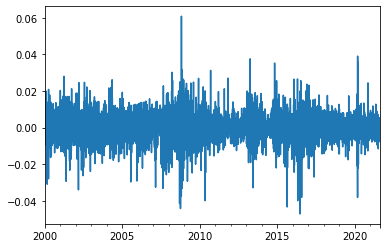

In [56]:
a.plot()

<AxesSubplot:>

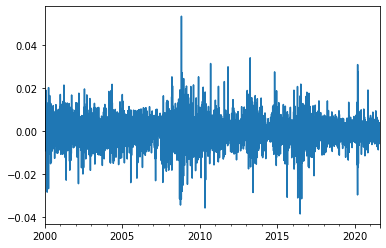

In [57]:
b.plot()

In [55]:
np.correlate(a.ffill()[1:], b.ffill()[1:])

array([0.25224991])

<AxesSubplot:ylabel='Cumulative returns'>

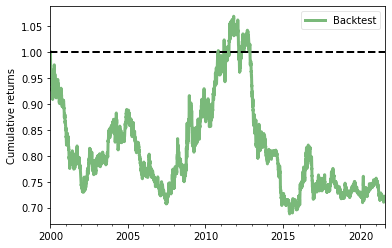

In [62]:
pf.plot_rolling_returns((1/px["USDJPY"].dropna(how = 'all', subset = ['PX_LAST'])["PX_LAST"]).diff())

<AxesSubplot:ylabel='Cumulative returns'>

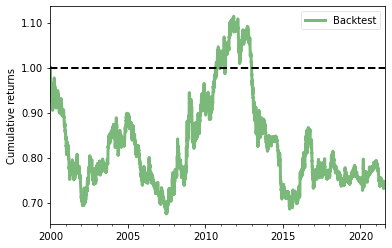

In [61]:
pf.plot_rolling_returns((1/px["USDJPY"].dropna(how = 'all', subset = ['PX_LAST'])["PX_LAST"]).pct_change())

Start date,2000-01-03
End date,2021-08-06
Total months,268
,Backtest
Annual return,-1.3%
Cumulative returns,-25.8%
Annual volatility,9.6%
Sharpe ratio,-0.09
Calmar ratio,-0.03
Stability,0.02
Max drawdown,-38.5%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,38.47,2011-10-28,2015-06-05,NaT,NaN
1,32.52,2000-01-03,2007-06-22,2010-08-24,2777
2,7.65,2011-03-17,2011-04-06,2011-07-13,85
3,4.57,2010-10-29,2010-11-29,2011-03-16,99
4,3.19,2010-09-14,2010-09-17,2010-10-06,17


c:\users\vin_s\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:418: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
c:\users\vin_s\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:418: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
c:\users\vin_s\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:418: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
c:\users\vin_s\appdata\local\programs\py

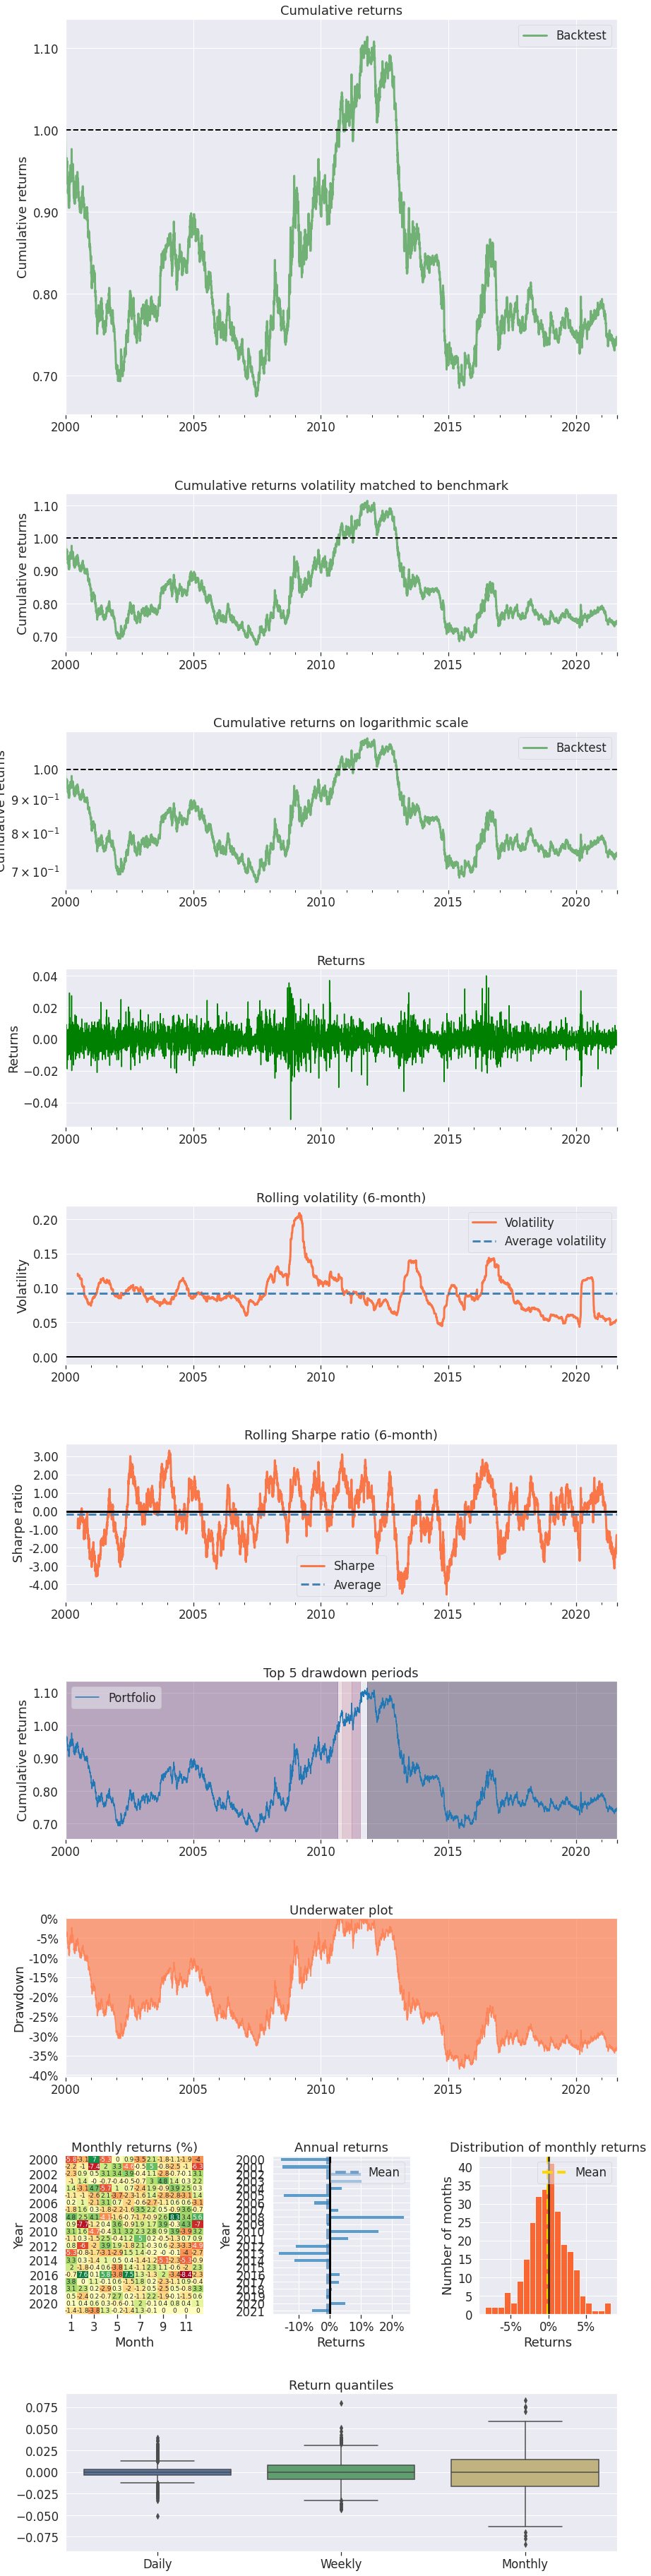

In [44]:
fig = pf.create_returns_tear_sheet((1/px["USDJPY"].dropna(how = 'all', subset = ['PX_LAST'])["PX_LAST"]).pct_change(), return_fig=True)

for ax in fig.axes:
        ax.tick_params(
        axis='x',           # changes apply to the x-axis
        which='both',       # both major and minor ticks are affected
        bottom=True,
        top=False,
        labelbottom=True)    # labels along the bottom edge are on